In [1]:
from ica_benchmark.io.load import Physionet_2009_Dataset, BCI_IV_Comp_Dataset, OpenBMI_Dataset
import mne
from pathlib import Path
from collections import namedtuple
import numpy as np
from itertools import product

mne.set_log_level(False)

physionet_dataset_folderpath = Path('/home/paulo/Documents/datasets/Physionet')
bci_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/')
bci_test_dataset_folderpath = Path('/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/')
openbmi_dataset_folderpath = Path('/home/paulo/Documents/datasets/OpenBMI/edf/')

physionet_dataset = Physionet_2009_Dataset(physionet_dataset_folderpath)
bci_dataset = BCI_IV_Comp_Dataset(bci_dataset_folderpath, test_folder=bci_test_dataset_folderpath)
openbmi_dataset = OpenBMI_Dataset(openbmi_dataset_folderpath)

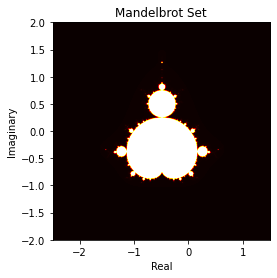

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def mandelbrot(c, max_iterations=1000):
    z = c
    n = 0
    while abs(z) <= 2 and n < max_iterations:
        z = z*z + c
        n += 1
    return n

def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iterations):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j], max_iterations)
    return (r1, r2, n3)

xmin, xmax, ymin, ymax = -2.5, 1.5, -2, 2
width, height = 1000, 1000
max_iterations = 1000

X, Y, Z = mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iterations)

plt.imshow(Z, extent=(xmin, xmax, ymin, ymax), cmap='hot')
plt.title("Mandelbrot Set")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.show()




In [2]:
from mne import Epochs

def make_epochs_splits_indexes(arr, n=None, n_splits=2, sizes=None, shuffle=False, seed=1):
    if isinstance(arr, (tuple, list)):
        arr = np.array(arr)
    np.random.seed(seed)
    if n is None:
        if isinstance(arr, Epochs):
            n = len(arr.events)
        else:
            n = len(arr)
    sizes = sizes or [1 / n_splits] * n_splits

    assert np.sum(sizes) == 1.
    
    sizes = np.cumsum(
        [0] + [int(size * n) for size in sizes]
    )
    
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    slices = [slice(start, end) for start, end in zip(sizes[:-1], sizes[1:])]
    indexes = [idx[s] for s in slices]
    return indexes

def make_epochs_splits(arr, n=None, n_splits=2, sizes=None, shuffle=False, seed=1):
    indexes = make_epochs_splits_indexes(arr, n=n, n_splits=n_splits, sizes=sizes, shuffle=shuffle, seed=seed)
    arrs = [arr[idx] for idx in indexes]
    return arrs

make_epochs_splits(np.linspace(10, 100, 20), sizes=[.3, .7], shuffle=False)

[array([10.        , 14.73684211, 19.47368421, 24.21052632, 28.94736842,
        33.68421053]),
 array([ 38.42105263,  43.15789474,  47.89473684,  52.63157895,
         57.36842105,  62.10526316,  66.84210526,  71.57894737,
         76.31578947,  81.05263158,  85.78947368,  90.52631579,
         95.26315789, 100.        ])]

In [3]:
from copy import deepcopy

class Splitter():
    
    INTER_SESSION = True
    INTER_SUBJECT = True
    TRAIN_TEST = True
    
    UNIQUE_SESSION = False
    
    SESSION_KWARGS = dict(intra=dict(), inter=dict())
    
    def __init__(self, dataset, uids, sessions, train_folds, load_kwargs=None, fold_sizes=None):
        self.dataset = dataset
        self.uids = uids
        self.sessions = sessions
        self.train_folds = train_folds
        self.load_kwargs = load_kwargs or load_kwargs
        self.fold_sizes = fold_sizes

    def inter_subject_splitting(self, shuffle=False, sizes=[.5, .5], seed=1):
        np.random.seed(seed)
        uids = deepcopy(self.uids)
        if shuffle:
            np.random.shuffle(uids)
        splits_uids = make_epochs_splits(uids, sizes=sizes)
        # [(info, epochs), (info, epochs), ...]
        splits = [
            (
                dict(
                    sessions=self.sessions,
                    train_folds=self.train_folds,
                    uid=split_uids
                ),
                mne.concatenate_epochs(
                    [
                        self.dataset.load_subject(uid, session=session, train=train, **self.load_kwargs)[0]
                        for session in self.sessions
                        for train in self.train_folds
                        for uid in split_uids
                    ]
                )
            )
            for split_uids in splits_uids
        ]
        return splits

    def inter_session_splitting(self):
        assert len(self.sessions) > 1, "You are using the inter session protocol, but only passed 1 session"
        splits = [
            (
                dict(uids=self.uids, sessions=[session], train_folds=self.train_folds),
                mne.concatenate_epochs(
                    [
                        self.dataset.load_subject(uid, session=session, train=train, **self.load_kwargs)[0]
                        for train
                        in self.train_folds
                    ]
                )
            )
            for uid in self.uids
            for session in self.sessions
        ]
        return splits

    def intra_session_default_splitting(self):
        
        assert len(self.sessions) == 1, "Your are using an intra session splitting but had more than 1 session"
        splits = [
            (
                dict(uid=self.uids, sessions=[session], train_folds=[train]),
                self.dataset.load_subject(uid, session=session, train=train, **self.load_kwargs)[0]
            )
            for session in self.sessions
            for train in self.train_folds
        ]
        return splits

    def intra_session_splitting(self, uid, session):
        epochs = mne.concatenate_epochs(
            [
                self.dataset.load_subject(uid, session=session, train=train, **self.load_kwargs)[0]
                for train in self.train_folds
            ]
        )
        splits = make_epochs_splits(
            epochs,
            n=len(epochs.events),
            sizes=self.fold_sizes
        )
        splits = [
            (
                dict(uid=self.uids, session=session, train_folds=self.train_folds, size=size),
                split
            )
            for split, size
            in zip(splits, self.fold_sizes)
        ]
        return splits


    def make_splits(self, inter_session=True, inter_subject=False):

        assert all(np.isin(self.uids, self.dataset.list_uids()))
        session_key = "inter" if inter_session else "intra"
        subject_key = "inter" if inter_subject else "intra"
        
        splits = list()

        # Inter session for the inter subject protocol does not make sense.
        # So, if inter_subject is true, inter_session does not matter
        if inter_subject:
            splits = self.inter_subject_splitting()
            yield splits
            
        # Intra subject
        else:
            
            for uid in self.uids:
                if inter_session:
                    splits = self.inter_session_splitting()
                    yield splits

                else:
                    
                    if self.fold_sizes is None:
                        splits = self.intra_session_default_splitting()
                    else:
                        assert len(self.sessions) == 1, "You are using the intra session protocol but passed more than 1 session"
                        session = self.sessions[0]
                        splits = self.intra_session_splitting(uid, session)
                        
                    yield splits
import numpy as np
kwargs = dict(
    inter_session=False,
    inter_subject=False
)
splitter = Splitter(
    openbmi_dataset,
    uids=["1", "2"],
    sessions=[1],
    train_folds=[True, False],
    load_kwargs=dict(
        reject=False
    )
#     fold_sizes=[.4, .6]
)
for j, splits in enumerate(splitter.make_splits(**kwargs)):
    print(f"FOLD {j}")
    for i, (info, split) in enumerate(splits):
        print(f"Split {i}")
        print("\tInfo", info)
        print("\tSplit", split)
        print()


NameError: name 'uid' is not defined

In [4]:
from itertools import product

class SplitArg():
    def __init__(self, name, arg_list, to_split):
        self.name = name
        self.arg_list = arg_list
        self.to_split = to_split
        

def group_iterator(*args):
    split_args_iter = [
        arg
        for arg
        in args
        if arg.to_split
    ]
    merge_args_iter = [
        arg
        for arg
        in args
        if not arg.to_split
    ]
    # Split loop
    for split_args in product(*[arg.arg_list for arg in split_args_iter]):
                
        split_arg_dict = {
            arg.name: split_args[i]
            for i, arg
            in enumerate(split_args_iter)
        }
        # Merge loop
        merge_args_list = list()
        for merge_args in product(*[arg.arg_list for arg in merge_args_iter]):
            merge_arg_dict = {
                arg.name: merge_args[i]
                for i, arg
                in enumerate(merge_args_iter)
            }
            run_kwargs = {**split_arg_dict, **merge_arg_dict}
            merge_args_list.append(run_kwargs)
        yield merge_args_list


load_kwargs=dict(
    tmin=1,
    tmax=3.5,
    reject=False
)

from copy import deepcopy
def split(dataset, uids, sessions, train_folds, fold_sizes, load_kwargs):
    kwargs_iterator = group_iterator(
        SplitArg("uid", uids, True),
        SplitArg("session", sessions, False),
        SplitArg("train", train_folds, True),
    )
    epochs_list = list()
    
    for splits_kwargs in kwargs_iterator:
        split_epochs = list()
#         for split_kwargs in splits_kwargs:
#             kwargs = deepcopy(split_kwargs)
#             uid = kwargs.pop("uid")
#             epochs, _ = dataset.load_subject(uid, **kwargs, **load_kwargs)
#             split_epochs.append(epochs)
        print(splits_kwargs)
        print()
#         if fold_sizes is not None:
#             split_epochs = mne.concatenate_epochs(split_epochs)
#             split_epochs = make_epochs_splits(split_epochs, n=len(split_epochs.events), sizes=fold_sizes)
#         yield split_epochs
        yield splits_kwargs

#         epochs_list.append(epochs)
#     epochs = mne.concatenate_epochs(epochs_list)
#     yield split
for k in split(openbmi_dataset, ["1", "2"], [1, 2], [True, False], None, load_kwargs):
#     print(k)
    pass

[{'uid': '1', 'train': True, 'session': 1}, {'uid': '1', 'train': True, 'session': 2}]

[{'uid': '1', 'train': False, 'session': 1}, {'uid': '1', 'train': False, 'session': 2}]

[{'uid': '2', 'train': True, 'session': 1}, {'uid': '2', 'train': True, 'session': 2}]

[{'uid': '2', 'train': False, 'session': 1}, {'uid': '2', 'train': False, 'session': 2}]



In [5]:
iters = [
    [1, 2, 3],
    ["a", "b", "c", "d"]
]
(1, "a"), (1, "b"), (1, "c"), (1, "d")

iters = [
    [1, 2, 3],
    [
        ["a", "b"], ["A", "B"]
    ],
    [True, False]
]
(1, "a"), (1, "b"), (1, "c"), (1, "d")


iters = [
    [1, 2, 3],
    [
        ["a", "b"], ["A", "B"]
    ]
]
(1, "a", "A"), (1, "a", "B"), (1, "b", "A"), (1, "b", "B")

def unpack_product(iters):
    iters = product(*iters)
    for iter_list in iters:
        print(iter_list)
        is_list = False
        for i, iter_value in enumerate(iter_list):
            is_list = is_list or isinstance(iter_value, list)
        for i, iter_value in enumerate(iter_list):
            iter_list[i] = [iter_list[i]] if is_list else iter_list[i]
    return iter_list
unpack_product(iters)

(1, ['a', 'b'])


TypeError: 'tuple' object does not support item assignment

In [158]:
from sklearn.model_selection import KFold, LeaveOneOut

cv = LeaveOneOut()
for a, b in cv.split(np.arange(100)):
    print(a)
    print(b)
    print()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]
[0]

[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]
[1]

[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]
[2]

[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25

In [138]:
import pandas as pd
from sklearn.model_selection import KFold, LeaveOneOut
from itertools import tee
from warnings import warn

def remove_key(d, k):
    return {
        key: value
        for key, value in d.items()
        if key != k
    }

class Split():
    
    def __init__(self, kwarg_dict_list, fold_sizes=None):
        self.kwargs_list = kwarg_dict_list
        self.fold_sizes = fold_sizes
    
    def to_dataframe():
        return pd.DataFrame.from_records(self.kwargs_list)

    def __repr__(self):
        dict_reps = [str(d) for d in self.kwargs_list]
        return "Split({})".format(",".join(dict_reps))
    
    def load_epochs(self, dataset, **load_kwargs):
        epochs = mne.concatenate_epochs(
            [
                dataset.load_subject(kwargs["uid"], **remove_key(kwargs, "uid"), **load_kwargs)[0]
                for kwargs in self.kwargs_list
            ]
        )
        return epochs


# df = pd.DataFrame(product(openbmi_dataset.list_uids(), ["1", "2"], [True, False]), columns=["uid", "session", "train"])

# k = ["uid", "session"]

uids = openbmi_dataset.list_uids()[:3]
sessions = [1, 2]
runs = [1, 2]


# for uid, session in product(uids, sessions):
#     a = df.query("uid == @uid").query("session == @session")
#     display(a)
                
class Splitter():
    
    INTER_SESSION = True
    INTER_SUBJECT = True
    TRAIN_TEST = True
    
    UNIQUE_SESSION = False
    
    SESSION_KWARGS = dict(intra=dict(), inter=dict())
    
    def default_cv_splitter(self):
        return KFold(4)
    
    def __init__(self, dataset, uids, sessions, runs, load_kwargs=None, cv_splitter=None, unsafe=False, intra_session_shuffle=False):
        self.dataset = dataset
        self.uids = uids
        self.sessions = sessions
        self.runs = runs
        self.load_kwargs = load_kwargs or load_kwargs
        self.cv_splitter = cv_splitter or self.default_cv_splitter()
        self.intra_session_shuffle = intra_session_shuffle
        
    def validate_config(self, mode, fold_sizes=None):
        valid_modes = [
            "inter_subject",
            "inter_session",
            "intra_session_intra_run",
            "intra_session_intra_run_merge",
            "intra_session_inter_run"
        ]
        
        assert mode in valid_modes, "Please choose one mode among the following: {}".format(", ".join(valid_modes))
        if mode == "inter_subject":
            if fold_sizes is not None:
                warn("You are using the inter_subject mode, so the fold_sizes argument will not be used")
#         if mode == "intra_session":
#             if len(self.runs) > 
        elif mode == "inter_session":
            if len(self.runs) > 1:
                warn("You are using inter session protocol with more than one run. All runs from each session will be concatenated and yielded in different steps.")

        elif (mode in ("intra_session_intra_run", "intra_session_intra_run_merge")):
            if fold_sizes is None:
                warn("You are using intra session protocol with no fold sizes. The splitter will only yield one epoch at time")

        elif (mode == "intra_session_inter_run"):
            if (len(self.runs) == 1):
                warn("You are using an intra session protocol, splitting by run, but only passed one run. The splitter can only yield one epoch at time (from the only run you passed as argument)")

    def inter_subject(self):
        for uid_splits_idxs in self.cv_splitter.split(self.uids):
            splits_uids = [uids[idx] for idx in uid_splits_idxs]
            yield [
                Split(
                    [
                        dict(
                            uid=uid,
                            session=session,
                            run=run
                        )
                        for uid in split_uids
                        for session in self.sessions
                        for run in self.runs
                    ]
                )
                for split_uids in splits_uids
            ]

    def inter_session(self):
        for uid in self.uids:
            yield [
                Split(
                    [
                        dict(
                            uid=uid,
                            session=session,
                            run=run
                        )
                        for run in self.runs
                    ]
                )
                for session in self.sessions
            ]

    def intra_session_inter_run(self):
        for uid in self.uids:
            for session in self.sessions:
                yield [
                    Split(
                        [
                            dict(
                                uid=uid,
                                session=session,
                                run=run
                            )
                        ]
                    )
                    for run in self.runs
                ]
    
    def intra_session_intra_run(self):
        for uid in self.uids:
            for session in self.sessions:
                for run in self.runs:
                    yield [
                        Split(
                            [
                                dict(
                                    uid=uid,
                                    session=session,
                                    run=run
                                )
                            ]
                        )
                    ]

    def intra_session_intra_run_merge(self):
        for uid in self.uids:
            for session in self.sessions:
                yield [
                    Split(
                        [
                            dict(
                                uid=uid,
                                session=session,
                                run=run
                            )
                            for run in self.runs
                        ]
                    )
                ]
                    
    def yield_splits_epochs(self, mode, fold_sizes=None):
        self.validate_config(mode, fold_sizes)

        split_fn_dict = dict(
            # Intra subject, inter session
            inter_session=self.inter_session,
            # Inter subject, will concatenate all sessions and runs
            inter_subject=self.inter_subject,
            # Intra subject, intra_session, inter run (will split runs)
            intra_session_inter_run=self.intra_session_inter_run,
            # Intra subject, intra_session, intra run (will split using fold sizes)
            intra_session_intra_run=self.intra_session_intra_run,
            # Intra subject, intra_session, intra run (will merge all runs and split using fold sizes)
            intra_session_intra_run_merge=self.intra_session_intra_run_merge,
        )

        split_fn = split_fn_dict[mode]
        for splits in split_fn():
            splits_epochs = [
                split.load_epochs(openbmi_dataset, **load_kwargs)
                for split in splits
            ]
            assert len(splits) == len(splits_epochs)
            if mode in ("intra_session_intra_run", "intra_session_intra_run_merge") and (fold_sizes is not None):
                assert len(splits_epochs) == 1
                epochs = splits_epochs[0]
                splits_epochs = make_epochs_splits(epochs, sizes=fold_sizes, shuffle=self.intra_session_shuffle)
            yield splits, splits_epochs
                    
splitter = Splitter(
    openbmi_dataset,
    uids=openbmi_dataset.list_uids()[:1],
    sessions=openbmi_dataset.SESSIONS,
#     runs=openbmi_dataset.RUNS,
    runs=[1, 2],
    load_kwargs=dict(
        reject=False
    ),
#     fold_sizes=None,
    cv_splitter=None,
    intra_session_shuffle=False
)
for splits, epochs in splitter.yield_splits_epochs(mode="intra_session_intra_run_merge", fold_sizes=[.3, .7]):
    print(splits)
    print(epochs)

/tmp/ipykernel_74596/3404827033.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(


[Split({'uid': '25', 'session': 1, 'run': 1},{'uid': '25', 'session': 1, 'run': 2})]
[<Epochs |  60 events (all good), -0.3 - 0.7 sec, baseline off, ~28.5 MB, data loaded,
 '0': 24
 '1': 36>, <Epochs |  140 events (all good), -0.3 - 0.7 sec, baseline off, ~66.4 MB, data loaded,
 '0': 76
 '1': 64>]


/tmp/ipykernel_74596/3404827033.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(


[Split({'uid': '25', 'session': 2, 'run': 1},{'uid': '25', 'session': 2, 'run': 2})]
[<Epochs |  60 events (all good), -0.3 - 0.7 sec, baseline off, ~28.5 MB, data loaded,
 '0': 24
 '1': 36>, <Epochs |  140 events (all good), -0.3 - 0.7 sec, baseline off, ~66.4 MB, data loaded,
 '0': 76
 '1': 64>]


In [155]:
class SplitArg():
    def __init__(self, name, arg_list, level=0):
        self.name = name
        self.arg_list = arg_list

    def __repr__(self):
        return "|<{}> {}: {}|".format(self.level, self.name, self.arg_list)

    
def get_iterator_arg()
def group_iterator(outside_arg_dict, inside_arg_dict):
    for outside_kwargs in product_dict(**outside_arg_dict):
        a = [
            Split(
                [
                    dict(
                        **outside_kwargs,
                        **inside_kwargs
                    )
                    for inside_kwargs in product_dict(**inside_arg_dict)
                ]
            )
        ]
        for s in a:
            print(s)

group_iterator(
    dict(
#         uid=[1, 2],
        session=[1, 2],
#         run=[1, 2]
    ),
    dict(
        uid=[1, 2],
#         session=[1, 2]
        run=[1, 2]
    )
)

Split({'session': 1, 'uid': 1, 'run': 1},{'session': 1, 'uid': 1, 'run': 2},{'session': 1, 'uid': 2, 'run': 1},{'session': 1, 'uid': 2, 'run': 2})
Split({'session': 2, 'uid': 1, 'run': 1},{'session': 2, 'uid': 1, 'run': 2},{'session': 2, 'uid': 2, 'run': 1},{'session': 2, 'uid': 2, 'run': 2})


In [143]:
def my_product(*inp):
    return (dict(zip(inp.keys(), values)) for values in product(*inp.values()))


list(product_dict(l1=l1, l2=l2))

[{'l1': 1, 'l2': 'a'},
 {'l1': 1, 'l2': 'b'},
 {'l1': 1, 'l2': 'c'},
 {'l1': 2, 'l2': 'a'},
 {'l1': 2, 'l2': 'b'},
 {'l1': 2, 'l2': 'c'},
 {'l1': 3, 'l2': 'a'},
 {'l1': 3, 'l2': 'b'},
 {'l1': 3, 'l2': 'c'}]

In [156]:
l1 = [1, 2]
l2 = [101, 102]
l3 = ["a", "b"]
l4 = ["A", "B"]

def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in product(*vals):
        yield dict(zip(keys, instance))
        
def group_iterator(outer_kwargs_list_dict=None, inner_kwargs_list_dict=None):
    
    for outside_kwargs in product_dict(**outer_kwargs_list_dict):
        splits = [
            Split(
                [
                    dict(
                        **outside_kwargs,
                        **inside_kwargs
                    )
                    for inside_kwargs in product_dict(**inner_kwargs_list_dict)
                ]
            )
        ]
        yield splits
        
a = group_iterator(dict(l1=l1, l2=l2), dict(l3=l3))
list(a)

[[Split({'l1': 1, 'l2': 101, 'l3': 'a'},{'l1': 1, 'l2': 101, 'l3': 'b'})],
 [Split({'l1': 1, 'l2': 102, 'l3': 'a'},{'l1': 1, 'l2': 102, 'l3': 'b'})],
 [Split({'l1': 2, 'l2': 101, 'l3': 'a'},{'l1': 2, 'l2': 101, 'l3': 'b'})],
 [Split({'l1': 2, 'l2': 102, 'l3': 'a'},{'l1': 2, 'l2': 102, 'l3': 'b'})]]

In [129]:
splits

[Split({'uid': '25', 'session': 2, 'run': 1}),
 Split({'uid': '25', 'session': 2, 'run': 2})]

In [82]:
epochs[0]

Number of events,100
Events,0: 501: 50
Time range,-0.300 – 0.700 sec
Baseline,off


In [25]:
openbmi_dataset._validate_run(1)

1

In [16]:
load_kwargs

{'reject': False}

In [11]:
train_folds = [True, False]
inside_iter = [1]
outside_iter = [True, False]
[
    Split(
        [
            dict(
                uid=1,
                session=1,
                train=train_fold
            )
            for train_fold in inside_iter
        ],
        None
    )
    for train_fold in outside_iter
]

[[{'uid': 1, 'session': 1, 'train': 1}],
 [{'uid': 1, 'session': 1, 'train': 1}]]

In [23]:
folds_epochs_list[1]

(<Epochs |  120 events (all good), -0.3 - 0.7 sec, baseline off, ~56.9 MB, data loaded,
  '0': 63
  '1': 57>,
 <Epochs |  120 events (all good), -0.3 - 0.7 sec, baseline off, ~56.9 MB, data loaded,
  '0': 63
  '1': 57>)

In [12]:
filepaths_df = openbmi_dataset.list_subject_filepaths()
uid = '25'
session = 1
train = True
(
    filepaths_df.query("uid == @uid")
    .query("train == @train")
    .query("session == @session")
    .path
)

108    /home/paulo/Documents/datasets/OpenBMI/edf/ses...
Name: path, dtype: object

In [13]:
filepaths_df.query("uid == @uid").query("train == @train").query("session == @session")

,path,train,session,uid
108,/home/paulo/Documents/datasets/OpenBMI/edf/ses...,True,1,25


In [195]:
split.kwargs_list

[{'uid': '25', 'session': '1', 'train': True},
 {'uid': '25', 'session': '1', 'train': False}]

In [120]:
uid

('48',)

In [76]:
from itertools import product

class SplitArg():
    def __init__(self, name, arg_list, level=0):
        self.name = name
        self.arg_list = arg_list
        self.level = level

    def __repr__(self):
        return "|<{}> {}: {}|".format(self.level, self.name, self.arg_list)

def group_iterator(*args):
    
    levels = sorted(set([arg.level for arg in args]))
    
    levels_args_iters = [
        [
            arg
            for arg in args
            if arg.level == level
        ]
        for level in levels
    ]
    print(levels_args_iters)
    # Split loop
    level_iterables = [
        product(*[arg.arg_list for arg in level_args_iter])
        for level_args_iter in levels_args_iters
    ]
    for all_level_args_lists in product(*level_iterables):
        split_arg_dict = {
#             arg.name: levels_args_iters[level].arg_list[i]
            levels_args_iters[level][i].name: arg_value
            for level, level_args_iter in enumerate(all_level_args_lists)
            for i, arg_value in enumerate(level_args_iter)
        }
        print(split_arg_dict)
        
#         merge_args_list = list()
#         for merge_args in product(*[arg.arg_list for arg in merge_args_iter]):
#             merge_arg_dict = {
#                 arg.name: merge_args[i]
#                 for i, arg
#                 in enumerate(merge_args_iter)
#             }
#             run_kwargs = {**split_arg_dict, **merge_arg_dict}
#             merge_args_list.append(run_kwargs)
        yield split_arg_dict


load_kwargs=dict(
    tmin=1,
    tmax=3.5,
    reject=False
)

from copy import deepcopy
def split(dataset, uids, sessions, train_folds, fold_sizes, load_kwargs):
    kwargs_iterator = group_iterator(
        SplitArg("uid", uids, 0),
        SplitArg("session", sessions, 0),
        SplitArg("train", train_folds, 0),
    )
    epochs_list = list()
    
    for splits_kwargs in kwargs_iterator:
        split_epochs = list()
#         for split_kwargs in splits_kwargs:
#             kwargs = deepcopy(split_kwargs)
#             uid = kwargs.pop("uid")
#             epochs, _ = dataset.load_subject(uid, **kwargs, **load_kwargs)
#             split_epochs.append(epochs)
#         print(splits_kwargs)
#         print()
#         if fold_sizes is not None:
#             split_epochs = mne.concatenate_epochs(split_epochs)
#             split_epochs = make_epochs_splits(split_epochs, n=len(split_epochs.events), sizes=fold_sizes)
        yield splits_kwargs
#         yield splits_kwargs

#         epochs_list.append(epochs)
#     epochs = mne.concatenate_epochs(epochs_list)
#     yield split
for k in split(openbmi_dataset, ["1", "2"], [1, 2], [True, False], None, load_kwargs):
#     print(k)
    pass

[[|<0> uid: ['1', '2']|, |<0> session: [1, 2]|, |<0> train: [True, False]|]]
{'uid': '1', 'session': 1, 'train': True}
{'uid': '1', 'session': 1, 'train': False}
{'uid': '1', 'session': 2, 'train': True}
{'uid': '1', 'session': 2, 'train': False}
{'uid': '2', 'session': 1, 'train': True}
{'uid': '2', 'session': 1, 'train': False}
{'uid': '2', 'session': 2, 'train': True}
{'uid': '2', 'session': 2, 'train': False}


In [ ]:
from itertools import product

class SplitArg():
    def __init__(self, name, arg_list, level=0):
        self.name = name
        self.arg_list = arg_list
        self.level = level

    def __repr__(self):
        return "|<{}> {}: {}|".format(self.level, self.name, self.arg_list)

def group_iterator(*args):
    
    levels = sorted([arg.level for arg in args])
    
    levels_args_iters = [
        [
            arg
            for arg in args
            if arg.level == level
        ]
        for level in levels
    ]
    # Split loop
    print([level_args for level_args in levels_args_iters])
    return
    level_iterables = [
        product(*[arg.arg_list for arg in level_args_iter])
        for level_args_iter in levels_args_iters
    ]
    print([list(a) for a in level_iterables])
    return
    for all_level_args_lists in product(*level_iterables):
                
        split_arg_dict = {
            arg.name: level_args_iter[i]
            for level_args_iter in all_level_args_lists
            for i, arg in enumerate(level_args_iter)
        }
        yield arg_dict
        # Merge loop
        
#         merge_args_list = list()
#         for merge_args in product(*[arg.arg_list for arg in merge_args_iter]):
#             merge_arg_dict = {
#                 arg.name: merge_args[i]
#                 for i, arg
#                 in enumerate(merge_args_iter)
#             }
#             run_kwargs = {**split_arg_dict, **merge_arg_dict}
#             merge_args_list.append(run_kwargs)
        yield merge_args_list


load_kwargs=dict(
    tmin=1,
    tmax=3.5,
    reject=False
)

from copy import deepcopy
def split(dataset, uids, sessions, train_folds, fold_sizes, load_kwargs):
    kwargs_iterator = group_iterator(
        SplitArg("uid", uids, True),
        SplitArg("session", sessions, False),
        SplitArg("train", train_folds, True),
    )
    epochs_list = list()
    
    for splits_kwargs in kwargs_iterator:
        split_epochs = list()
#         for split_kwargs in splits_kwargs:
#             kwargs = deepcopy(split_kwargs)
#             uid = kwargs.pop("uid")
#             epochs, _ = dataset.load_subject(uid, **kwargs, **load_kwargs)
#             split_epochs.append(epochs)
#         print(splits_kwargs)
#         print()
#         if fold_sizes is not None:
#             split_epochs = mne.concatenate_epochs(split_epochs)
#             split_epochs = make_epochs_splits(split_epochs, n=len(split_epochs.events), sizes=fold_sizes)
        yield splits_kwargs
#         yield splits_kwargs

#         epochs_list.append(epochs)
#     epochs = mne.concatenate_epochs(epochs_list)
#     yield split
for k in split(openbmi_dataset, ["1", "2"], [1, 2], [True, False], None, load_kwargs):
    print(k)
    pass

In [76]:
len(k)

2

In [23]:
from itertools import product
    
class SplitArg():
    def __init__(self, name, arg_list, to_split):
        self.to_split = to_split
        self.arg_list = arg_list
        self.name = name

DEFAULT_FOLDS = [True, False]
DEFAULT_SESSIONS = [1, 2]
DEFAULT_UIDS = ["1"]

def split(dataset, uids, sessions, train_folds, fold_sizes, load_kwargs):
    
    args = [uids, sessions, train_folds, fold_sizes]
    split_args_iter = [
        arg
        for arg
        in [uids, sessions, train_folds]
        if arg.to_split
    ]
    merge_args_iter = [
        arg
        for arg
        in [uids, sessions, train_folds]
        if not arg.to_split
    ]
    
    data = dict()
    
    # Split loop
    for split_args in product(*[arg.arg_list for arg in split_args_iter]):
                
        # Merge loop
        split_arg_dict = {
            arg.name: split_args[i]
            for i, arg
            in enumerate(split_args_iter)
        }
        epochs_list = list()
        for merge_args in product(*[arg.arg_list for arg in merge_args_iter]):
            merge_arg_dict = {
                arg.name: merge_args[i]
                for i, arg
                in enumerate(merge_args_iter)
            }
            run_kwargs = {**split_arg_dict, **merge_arg_dict, **load_kwargs}
            print(run_kwargs)
#             epochs, _ = dataset.load_subject(**run_kwargs)
#             epochs_list.append(epochs)
        
        if fold_sizes is not None:
            epochs = mne.concatenate_epochs(epochs_list)
            idx = np.arange(len(epochs))
            np.random.

        print()

split(
    None,
    SplitArg("uid", ["A", "B", "C"], False),
    SplitArg("session", [1, 2, 3], True),
    SplitArg("train", [True, False], False),
    [.3, .2, .5],
    dict()
)

{'session': 1, 'uid': 'A', 'train': True}
{'session': 1, 'uid': 'A', 'train': False}
{'session': 1, 'uid': 'B', 'train': True}
{'session': 1, 'uid': 'B', 'train': False}
{'session': 1, 'uid': 'C', 'train': True}
{'session': 1, 'uid': 'C', 'train': False}

{'session': 2, 'uid': 'A', 'train': True}
{'session': 2, 'uid': 'A', 'train': False}
{'session': 2, 'uid': 'B', 'train': True}
{'session': 2, 'uid': 'B', 'train': False}
{'session': 2, 'uid': 'C', 'train': True}
{'session': 2, 'uid': 'C', 'train': False}

{'session': 3, 'uid': 'A', 'train': True}
{'session': 3, 'uid': 'A', 'train': False}
{'session': 3, 'uid': 'B', 'train': True}
{'session': 3, 'uid': 'B', 'train': False}
{'session': 3, 'uid': 'C', 'train': True}
{'session': 3, 'uid': 'C', 'train': False}



In [77]:
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.metrics import balanced_accuracy_score

class GetData(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        filter_kwargs = dict(
            method="iir",
            iir_params=dict(
                order=5,
                ftype="butter"
            )
        )
        return X.load_data().filter(8, 30, **filter_kwargs).get_data()


# kwargs = dict(
#     uids=["1", "2", "3", "4"],
#     inter_session=False,
#     inter_subject=True,
#     sessions=[2],
#     train_folds=[True, False],
#     fold_sizes=[.5, .5],
#     load_kwargs=dict(
#         reject=False
#     )
# )
kwargs = dict(
    uids=["1", "2", "3", "4"],
    inter_session=False,
    inter_subject=False,
    sessions=[1],
    train_folds=[True, False],
    fold_sizes=[.25, .75],
    load_kwargs=dict(
        tmin=1,
        tmax=3.5,
        reject=False
    )
)
for j, splits in enumerate(OpenBMI_Splitter(openbmi_dataset).make_splits(**kwargs)):
    infos = [info for info, split in splits]
    splits = [split for info, split in splits]
    print(infos)
    clf = make_pipeline(
        GetData(),
        CSP(5, log=True),
        LDA()
    )
    train_epochs = splits[0]
    train_labels = train_epochs.events[:, 2]
    
    test_epochs = splits[1]
    test_labels = test_epochs.events[:, 2]
    
    clf.fit(train_epochs, train_labels)
    pred = clf.predict(test_epochs)
    acc = balanced_accuracy_score(test_labels, pred)
    print(acc)

/tmp/ipykernel_9466/3590559943.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(


[{'uid': '1', 'session': 1, 'train_folds': [True, False], 'size': 0.25}, {'uid': '1', 'session': 1, 'train_folds': [True, False], 'size': 0.75}]
0.5903271692745377


/tmp/ipykernel_9466/3590559943.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(


[{'uid': '2', 'session': 1, 'train_folds': [True, False], 'size': 0.25}, {'uid': '2', 'session': 1, 'train_folds': [True, False], 'size': 0.75}]
0.8466749866286325


/tmp/ipykernel_9466/3590559943.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(


[{'uid': '3', 'session': 1, 'train_folds': [True, False], 'size': 0.25}, {'uid': '3', 'session': 1, 'train_folds': [True, False], 'size': 0.75}]
0.8866999465145302


/tmp/ipykernel_9466/3590559943.py:107: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(


[{'uid': '4', 'session': 1, 'train_folds': [True, False], 'size': 0.25}, {'uid': '4', 'session': 1, 'train_folds': [True, False], 'size': 0.75}]
0.47759601706970123


In [71]:
train_labels

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0])

In [46]:
[f"{i} {j}" for i in range(3) for j in range(3)]

['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '2 0', '2 1', '2 2']

In [20]:
def split_array(arr, n_splits=2, sizes=None):
    n = len(arr)
    sizes = sizes or [1 / n] * n_splits
    assert np.sum(sizes) == 1.
    sizes = [int(size * n) for size in sizes]
    sizes = [0] + sizes
    sizes = np.cumsum(sizes)
    slices = [slice(start, end) for start, end in zip(sizes[:-1], sizes[1:])]
    arrs = [arr[s] for s in slices]
    return arrs

arrs = split_array(np.random.rand(100), sizes=[.2, .3, .1, .4])
list(map(len, arrs))

[20, 30, 10, 40]

In [44]:
split_array(openbmi_dataset.list_uids(), sizes=[.2, .3, .5])

[array(['25', '15', '41', '12', '37', '2', '42', '6', '52', '18'],
       dtype=object),
 array(['38', '30', '34', '5', '11', '44', '29', '8', '17', '33', '46',
        '23', '19', '4', '13', '22'], dtype=object),
 array(['35', '45', '36', '39', '16', '50', '10', '53', '7', '28', '27',
        '14', '32', '20', '31', '51', '24', '9', '21', '40', '47', '26',
        '49', '54', '43', '1', '3'], dtype=object)]

In [41]:
e = bci_dataset.load_subject("1")[0]
split_array(e, n=len(e.events), sizes=[.2, .8])

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


[<Epochs |  57 events (good & bad), -0.3 - 0.7 sec, baseline off, ~26 kB, data not loaded>,
 <Epochs |  230 events (good & bad), -0.3 - 0.7 sec, baseline off, ~26 kB, data not loaded>]